# Introduction
I was tasked to predict each player's on-base percentage in the 2021 season given only his plate
appearances(PA) and on-base percentages(OBP) in prior seasons.  I was given a file that had over 500 players that needed to have their OBP predicted for the 2021 season.  This study and analysis will use machine learning techniques to uncover key factors influencing OBP and to develop models with high predictive accuracy. This analysis includes data preprocessing, feature engineering, model training, evaluation, and hyperparameter tuning to identify the most effective approach.

## 1. Importing Required Libraries

In [8]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

## 2. Setting Global Seeds

In [10]:
# Set global seeds for reproducibility
np.random.seed(42)
random.seed(42)

## 3. Loading / Inspecting Data 

In [12]:
# Load data into pandas dataframe
%cd "C:\Users\curna\Desktop\Data"
df = pd.read_csv('obp.csv')
# Display first few rows to understand dataframe
df.head()

C:\Users\curna\Desktop\Data


,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,0.162,55.0,0.218,262.0,0.302
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315
4,Nick Fortes,21538,1996-11-11,34,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Check columns for null values
df.isnull().sum()

Name            0
playerid        0
birth_date      0
PA_21           0
OBP_21          0
PA_20         106
OBP_20        106
PA_19         135
OBP_19        135
PA_18         213
OBP_18        213
PA_17         274
OBP_17        274
PA_16         325
OBP_16        325
dtype: int64

In [14]:
# Use the describe method to get high level understanding of data
#df.describe()

## 4. Visualizing the Relationship between Plate Appearances (PA) and On-Base Percentage (OBP)

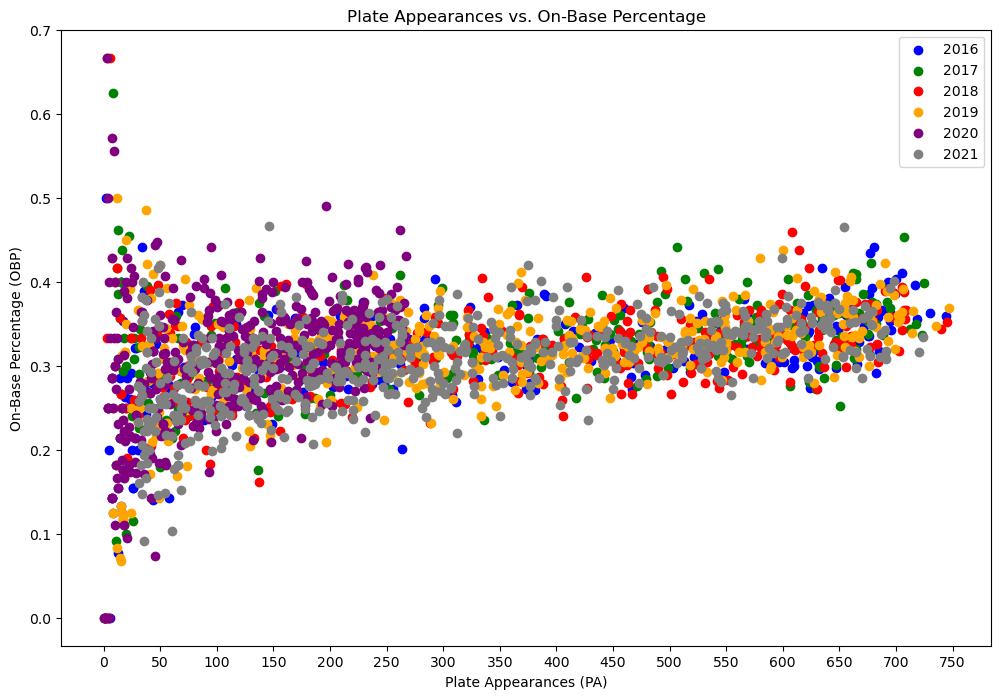

In [16]:
years = ['16', '17', '18', '19', '20', '21']
# Define custom colors for each year
colors = ['blue', 'green', 'red', 'orange', 'purple', 'gray']

# Create figure object and set figure size
plt.figure(figsize=(12, 8))

# Loop through each year and plot with specific color
for year, color in zip(years, colors):
    plt.scatter(df[f'PA_{year}'], df[f'OBP_{year}'], label=f'20{year}', color=color)

plt.xticks(np.arange(0, 800, 50))

# Add title, legend, and x, y labels
plt.xlabel('Plate Appearances (PA)')
plt.ylabel('On-Base Percentage (OBP)')
plt.title('Plate Appearances vs. On-Base Percentage')
plt.legend()
plt.show()

## 5. Data Cleaning and Preparation modeling.


In [64]:
# Filter out players with fewer than 150 total plate appearances across multiple seasons
df = df[df[['PA_16', 'PA_17', 'PA_18', 'PA_19', 'PA_20']].sum(axis=1) >= 150]

# Replace missing values in both OBP and PA columns with their respective medians
years = ['16', '17', '18', '19', '20', '21']
for year in years:
    df[f'OBP_{year}'] = df[f'OBP_{year}'].fillna(df[f'OBP_{year}'].median())
    df[f'PA_{year}'] = df[f'PA_{year}'].fillna(df[f'PA_{year}'].median())

# Calculate player's age in 2021 by subtracting birth year from 2021
df['age'] = 2021 - pd.to_datetime(df['birth_date']).dt.year


## 6. Correlation Analysis in Subsequent Steps.


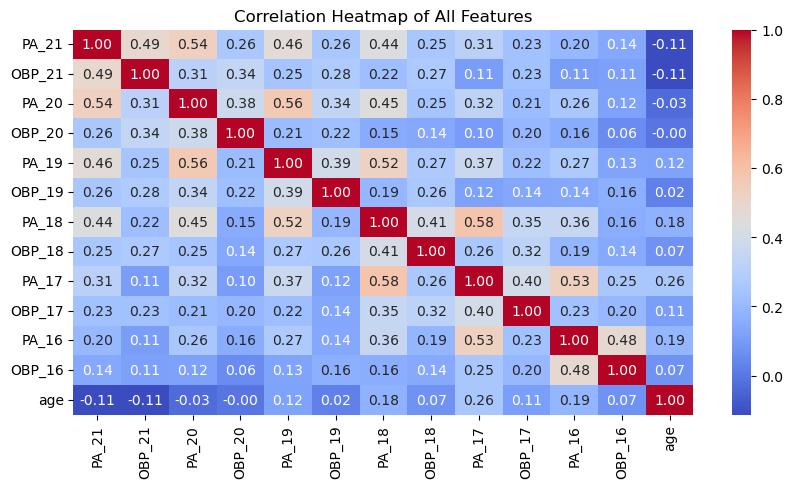

In [21]:
# Select relevant columns to be used as features and target variables
data_cols = ['PA_21', 'OBP_21', 'PA_20', 'OBP_20', 'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16', 'OBP_16', 'age']

# Initialize figure and specify its size
plt.figure(figsize=(10, 5))

# Calculate the correlation matrix for the chosen features
correlation_matrix = df[data_cols].corr()

# Generate a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set the title for the heatmap
plt.title('Correlation Heatmap of All Features')
plt.show()

## 7. Feature Engineering

In [23]:
# Generate a weighted OBP metric, giving more significance to recent years
df['OBP_weighted'] = (df['OBP_16'] * 0.1 + df['OBP_17'] * 0.2 
                      + df['OBP_18'] * 0.25 + df['OBP_19'] * 0.3 
                      + df['OBP_20'] * 0.35)

# Calculate OBP trends to reflect how performance changes between consecutive seasons
df['OBP_trend_1920'] = df['OBP_20'] - df['OBP_19']
df['OBP_trend_1819'] = df['OBP_19'] - df['OBP_18']

## 8. Data Preparation for Modelingn test data.


In [25]:
# Specify the feature columns and the target variable for prediction
features = ['PA_20', 'OBP_20', 'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16', 'OBP_16',
            'age', 'OBP_weighted', 'OBP_trend_1920', 'OBP_trend_1819']
target = 'OBP_21'

# Split the data into training and test sets, ensuring results can be reproduced
x_train, x_test, y_train, y_test = train_test_split(df[features], df[target], train_size=0.7, test_size=0.3, random_state=42)

## 9. Model Training

In [27]:
# Create a dictionary of models to be evaluated
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest Regression': RandomForestRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'ElasticNet Regression': ElasticNet(),
    'XGBoost': XGBRegressor()
}

# Train each model using the training dataset
for model in models.values():
    model.fit(x_train, y_train)

## 10. Model Evaluation

In [29]:
# Create a function to assess the accuracy of model predictions
def evaluate_model(model, x_test, y_test):
    # Generate predictions for the test dataset
    predictions = model.predict(x_test)
    # Compute the Mean Squared Error between actual and predicted values
    mse = mean_squared_error(y_test, predictions)
    # Compute the Coefficient of Determination to assess model performance
    r2 = r2_score(y_test, predictions)
    print(f'MSE: {mse:.4f} and R2: {r2:.4f}')

# Assess each model's performance
for name, model in models.items():
    print(f'Evaluating {name}:')
    evaluate_model(model, x_test, y_test)

Evaluating Linear Regression:
MSE: 0.0020 and R2: 0.1372
Evaluating Ridge Regression:
MSE: 0.0020 and R2: 0.1515
Evaluating Lasso Regression:
MSE: 0.0022 and R2: 0.0524
Evaluating Random Forest Regression:
MSE: 0.0021 and R2: 0.1066
Evaluating Decision Tree Regressor:
MSE: 0.0032 and R2: -0.3641
Evaluating Gradient Boosting:
MSE: 0.0025 and R2: -0.0630
Evaluating AdaBoost:
MSE: 0.0020 and R2: 0.1401
Evaluating ElasticNet Regression:
MSE: 0.0021 and R2: 0.0807
Evaluating XGBoost:
MSE: 0.0024 and R2: -0.0285


## 11. Comparison of Model Predictions

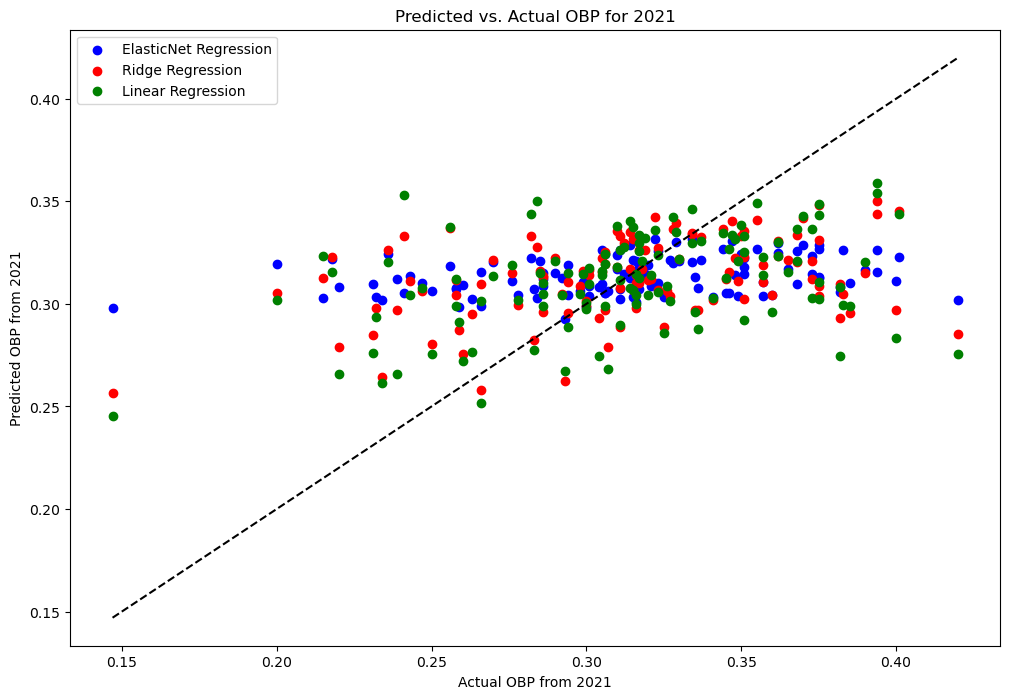

In [31]:
# Select the top-performing models for comparison
best_models = ['ElasticNet Regression', 'Ridge Regression', 'Linear Regression']

# Initialize the figure for plotting
plt.figure(figsize=(12, 8))

# Define a list of colors for the models
colors = ['blue', 'red', 'green']  # dark brown

# Iterate through each of the selected models to plot predictions
for i in range(len(best_models)):
    # Retrieve the model from the dictionary
    model = models[best_models[i]]
    # Generate predictions using the test dataset
    predictions = model.predict(x_test)
    # Add the predictions to the scatter plot with specified colors
    plt.scatter(y_test, predictions, label=f'{best_models[i]}', color=colors[i])

# Add a reference line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')

# Set plot labels and title
plt.xlabel('Actual OBP from 2021')
plt.ylabel('Predicted OBP from 2021')
plt.title('Predicted vs. Actual OBP for 2021')
plt.legend()
plt.show()

## 12. Analyzing Feature Importance in Ridge Regression

In [33]:
# Choose the Ridge Regression model for analysis
model = models['Ridge Regression']

# Retrieve the coefficients from the trained model
coefficients = model.coef_

# Create a dataframe to showcase feature importance
# *** Calculate the absolute values of the coefficients to highlight significant negative 
# correlations (e.g., increased age has a strong negative correlation with OBP) ***
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': [round(abs(c), 6) for c in coefficients]
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

           Feature  Importance
7           OBP_17    0.062803
11    OBP_weighted    0.062336
1           OBP_20    0.054649
5           OBP_18    0.054363
3           OBP_19    0.051750
9           OBP_16    0.015321
12  OBP_trend_1920    0.002899
13  OBP_trend_1819    0.002613
10             age    0.002192
0            PA_20    0.000125
6            PA_17    0.000021
4            PA_18    0.000015
8            PA_16    0.000010
2            PA_19    0.000009


## 13. Feature Selection Using Recursive Feature Elimination (RFE)

In [35]:
# Initialize Recursive Feature Elimination (RFE) using the Ridge model, selecting the top 10 features
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit the RFE model to the training data
rfe.fit(x_train, y_train)

# Retrieve the features selected by RFE
selected_features = x_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Define the target variable for prediction
target = 'OBP_21'

# Split the data into training and testing subsets (ensuring reproducibility)
x_train, x_test, y_train, y_test = train_test_split(df[selected_features], df[target], train_size=0.7, test_size=0.3, random_state=42)

Selected Features: Index(['PA_20', 'OBP_20', 'OBP_19', 'OBP_18', 'OBP_17', 'OBP_16', 'age',
       'OBP_weighted', 'OBP_trend_1920', 'OBP_trend_1819'],
      dtype='object')


## 14. Hyperparameter Tuning for Ridge Regression

In [37]:
# Initialize a new Ridge Regression model
ridge = Ridge()

# Define a parameter grid to explore optimal values for alpha
param_grid = {'alpha': np.logspace(-5, 5, 50)}  # Values from 0.00001 to 100,000

# Use GridSearchCV to find the best alpha value through cross-validation
# The scoring method is based on the negative mean squared error
ridge = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error')

# Fit the model to the training data
ridge.fit(x_train, y_train)

# Output the best alpha value for the Ridge Regression model
print(f"Best alpha for Ridge Regression: {ridge.best_params_['alpha']}")

Best alpha for Ridge Regression: 0.49417133613238384


## 15. Optimizing and Evaluating the Ridge Regression Model

In [39]:
# Instantiate a new Ridge Regression model with the optimal alpha value
best_ridge_model = Ridge(alpha=ridge.best_params_['alpha'])

# Fit the optimized model to the training data
best_ridge_model.fit(x_train, y_train)

# Evaluate the performance of the model on the test data
evaluate_model(best_ridge_model, x_test, y_test)

MSE: 0.0020 and R2: 0.1550


## 16. Final Predictions of All OBP

In [41]:
# Assign the best Ridge Regression model to a variable for predictions
model = best_ridge_model

# Generate predictions using the test dataset
predictions = model.predict(x_test)

# Calculate the absolute differences between actual values and model predictions
errors = abs(y_test - predictions)

# Create a DataFrame to compare actual and predicted values along with the errors
error_df = pd.DataFrame({
    'Player': df.loc[x_test.index, 'Name'],
    'Actual': np.round(y_test, 3),
    'Predicted': np.round(predictions, 3),
    'Error': np.round(errors, 3)
})

# Sort the DataFrame by the 'Error' column
closest_predictions = error_df.sort_values(by='Error')

# Set display options to show all rows
pd.set_option('display.max_rows', None)  # None means unlimited

# Print all results
print(closest_predictions)

# Optionally, reset to default after printing if needed
pd.reset_option('display.max_rows')


                    Player  Actual  Predicted  Error
112          Mitch Haniger   0.318      0.318  0.000
222            Joey Wendle   0.319      0.320  0.001
333          Oscar Mercado   0.300      0.299  0.001
441           Elvis Andrus   0.294      0.295  0.001
287         Miguel Cabrera   0.316      0.318  0.002
138        Eduardo Escobar   0.314      0.312  0.002
322              Jake Lamb   0.306      0.303  0.003
382              Jon Berti   0.311      0.315  0.004
232           Joc Pederson   0.310      0.314  0.004
218            Colin Moran   0.334      0.329  0.005
245         Brett Phillips   0.300      0.295  0.005
86            Willy Adames   0.337      0.332  0.005
440           Stephen Vogt   0.283      0.277  0.006
97          Avisail Garcia   0.330      0.324  0.006
296           Abraham Toro   0.315      0.308  0.007
157            Brad Miller   0.321      0.314  0.007
87           Jorge Polanco   0.323      0.331  0.008
313        Tucker Barnhart   0.317      0.309 

## 17. Distribution of Errors based on predictions

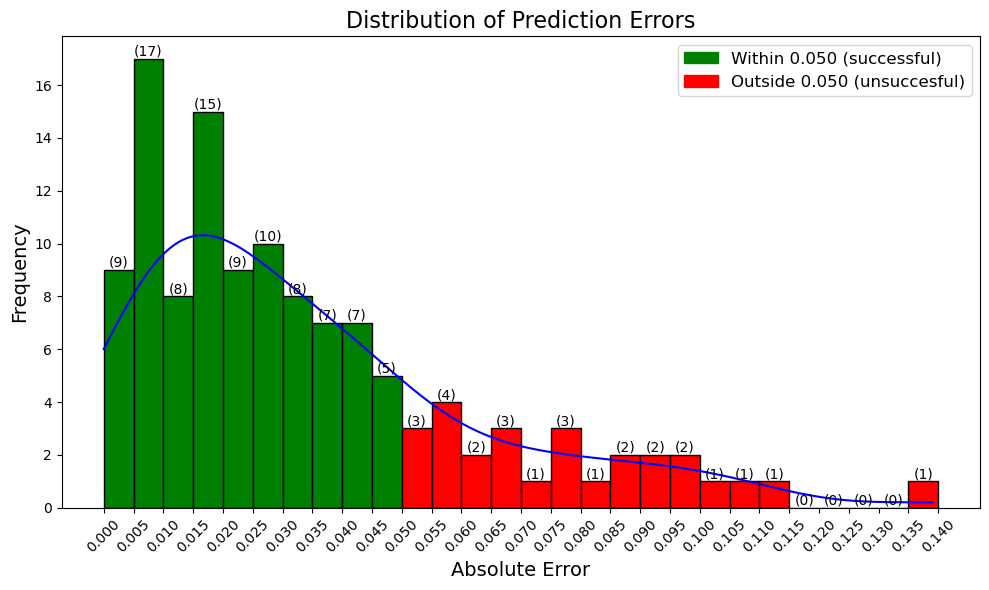

In [123]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a histogram for errors with a specified number of bins
histogram = sns.histplot(closest_predictions['Error'], bins=np.arange(0, 0.145, 0.005), kde=True, color='blue')

# Set title and labels
plt.title('Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Absolute Error', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Set x-ticks to show all increments
plt.xticks(np.arange(0, 0.145, 0.005), rotation=45)

# Initialize counters for predictions within and outside the 0.045 range
within_range_count = 0
outside_range_count = 0

# Get the bar heights and positions, and set the color of each bar based on the x-axis value
for bar in histogram.patches:
    x_value = bar.get_x() + bar.get_width() / 2  # Get the x-axis value for the bar
    if x_value <= 0.050:  # Check if the x-axis value is less than 0.045
        bar.set_facecolor('green')
        within_range_count += bar.get_height()  # Increment within-range count
    else:
        bar.set_facecolor('red')
        outside_range_count += bar.get_height()  # Increment outside-range count
    
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'({int(height)})', ha='center', va='bottom', fontsize=10)

# Create a legend (key) in the top right corner
plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='red')],
           labels=['Within 0.050 (successful)', 'Outside 0.050 (unsuccesful)'], loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

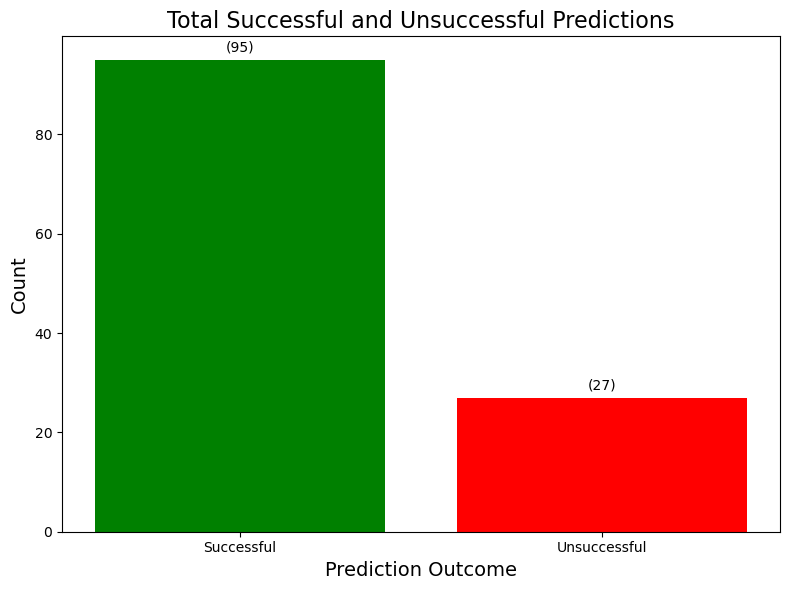

In [125]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Create a bar chart for successful and unsuccessful counts
plt.bar(['Successful', 'Unsuccessful'], [within_range_count, outside_range_count], color=['green', 'red'])

# Set title and labels
plt.title('Total Successful and Unsuccessful Predictions', fontsize=16)
plt.xlabel('Prediction Outcome', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add total count above each bar
for i, count in enumerate([within_range_count, outside_range_count]):
    plt.text(i, count + 1, f'({int(count)})', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()